<a href='https://www.latos.ai'> <img src='../logo_latos.jpeg' style="width: 200px;" align="right"/></a>
*Esse notebook faz parte do curso de [Python e Ciência de Dados para a Indústria](https://www.latos.ai/academy/python-e-ciencia-de-dados) da [Latos Academy](https://www.latos.ai).*

Latos© copyright 2022. All Rights Reserved.

# Dados industriais - Dados de malha de controle

Mais informações em: [Industrial datasets and a tool for SISO control loops data visualization and analysis ](https://www.sciencedirect.com/science/article/abs/pii/S0098135420312412)


In [1]:
from pathlib import Path
import datetime as dt

import numpy as np
import pandas as pd
from scipy import signal

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px

my_figsize = (10, 6)

In [2]:
root_dir = Path.cwd().parents[1]
data_dir = root_dir / 'data'

## Explorando os dados

In [3]:
# carregar dados na forma HDF5
data = pd.HDFStore(data_dir / 'raw.h5', mode='r')

# consultado as tabelas
data.keys()

ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

In [4]:
data['/TIC52/PV'].head()

Values  Quality
Time                                      
2017-10-06 12:00:00.964 -0.010827        2
2017-10-06 12:00:03.023 -0.010728        2
2017-10-06 12:00:05.083 -0.010492        2
2017-10-06 12:00:07.142 -0.010219        2
2017-10-06 12:00:09.201 -0.009814        2

In [5]:
data['/TIC52/PV'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84482 entries, 2017-10-06 12:00:00.964000 to 2017-10-08 23:59:58.075000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Values   84482 non-null  float64
 1   Quality  84482 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.9 MB


In [6]:
data['/TIC52/PV'].describe()

Values  Quality
count  84482.000000  84482.0
mean      -0.023927      2.0
std        0.129363      0.0
min       -0.500000      2.0
25%       -0.080509      2.0
50%       -0.005679      2.0
75%        0.033045      2.0
max        0.500000      2.0

## Visualização dos dados


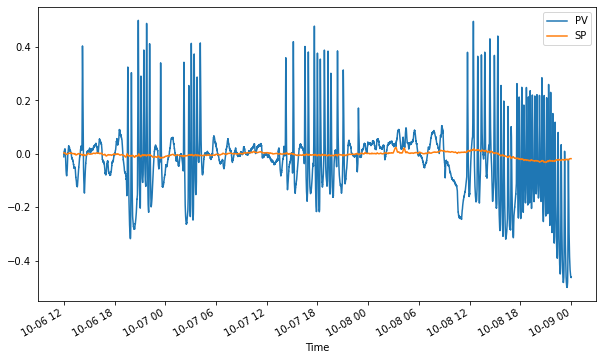

In [7]:
loop = '/TIC52'

pv = data[loop+'/PV']['Values']
sp = data[loop+'/SP']['Values']

plt.figure(figsize=my_figsize)
pv.plot(label='PV')
sp.plot(label='SP')

plt.legend()
plt.show()

In [8]:
ind_ini = pv.index > dt.datetime(2017, 10, 8, 12)
ind_fim = pv.index < dt.datetime(2017, 10, 9, 0)

pv_select = pv[ind_ini & ind_fim]

In [9]:
def select_range(df, ini, fim):
    ind_ini = df.index > ini
    ind_fim = df.index < fim

    return df[ind_ini & ind_fim]


ini = dt.datetime(2017, 10, 8, 12)
fim = dt.datetime(2017, 10, 9, 0)

pv_select = select_range(pv, ini, fim)
sp_select = select_range(sp, ini, fim)
sp_select

Time
2017-10-08 12:00:00.014    0.009754
2017-10-08 12:00:06.192    0.009674
2017-10-08 12:00:10.311    0.009623
2017-10-08 12:00:16.473    0.009573
2017-10-08 12:00:20.592    0.009542
                             ...   
2017-10-08 23:59:36.499   -0.018020
2017-10-08 23:59:40.586   -0.018012
2017-10-08 23:59:46.764   -0.018010
2017-10-08 23:59:50.867   -0.017973
2017-10-08 23:59:57.045   -0.017955
Name: Values, Length: 7108, dtype: float64

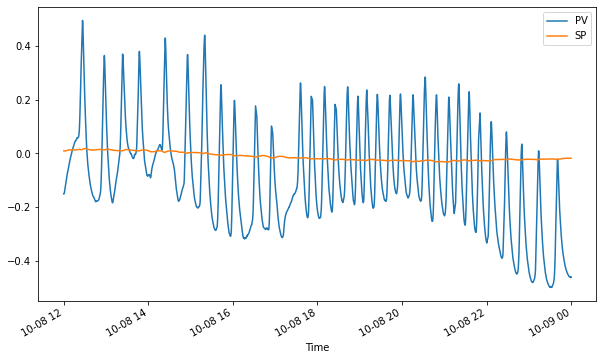

In [10]:
plt.figure(figsize=my_figsize)
pv_select.plot(label='PV')
sp_select.plot(label='SP')

plt.legend()
plt.show()

## Indicador de desempenho do controlador

In [11]:
pv_res = pv_select.resample('1min').mean()
sp_res = sp_select.resample('1min').mean()

<AxesSubplot:xlabel='Time'>

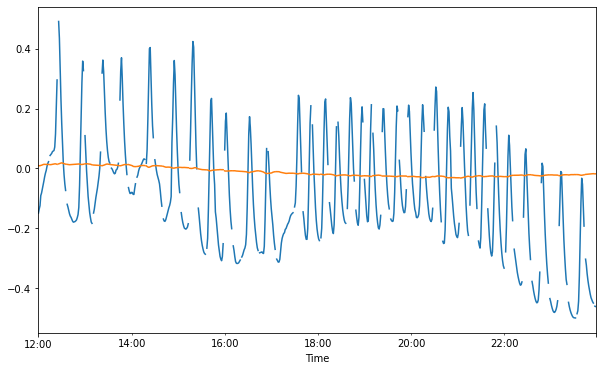

In [12]:
plt.figure(figsize=my_figsize)

pv_res.plot()
sp_res.plot()

In [13]:
pv_int = pv_res.interpolate()
sp_int = sp_res.interpolate()

<AxesSubplot:xlabel='Time'>

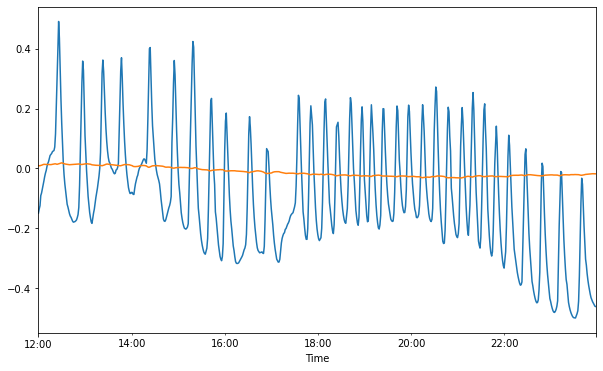

In [14]:
plt.figure(figsize=my_figsize)

pv_int.plot()
sp_int.plot()

In [15]:
np.mean(abs(pv_int - sp_int))

0.16851531486725596

## Filtro de ruido

<AxesSubplot:xlabel='Time'>

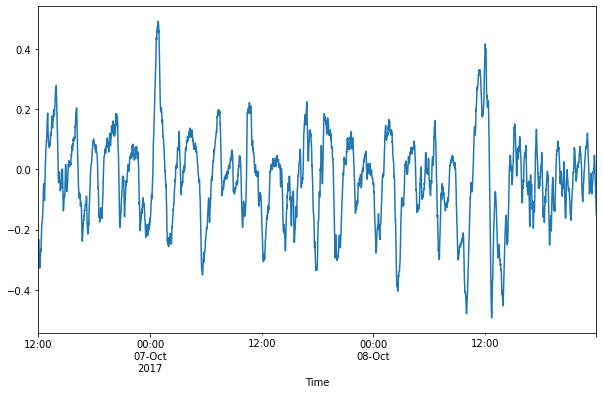

In [16]:
pv = data['/LIC44/PV']['Values']
pv_res = pv.resample('1min').mean()
pv_int = pv_res.interpolate('linear')

plt.figure(figsize=my_figsize)
pv_int.plot()

In [17]:
pv_mov_average = pv_int.rolling(window=50).mean()

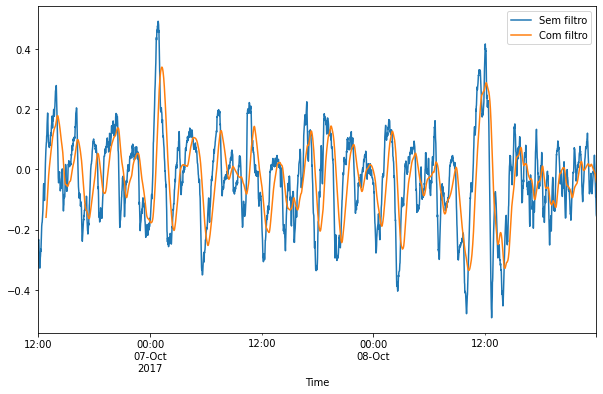

In [18]:
plt.figure(figsize=my_figsize)
pv_int.plot(label='Sem filtro')
pv_mov_average.plot(label='Com filtro')
plt.legend()
plt.show()

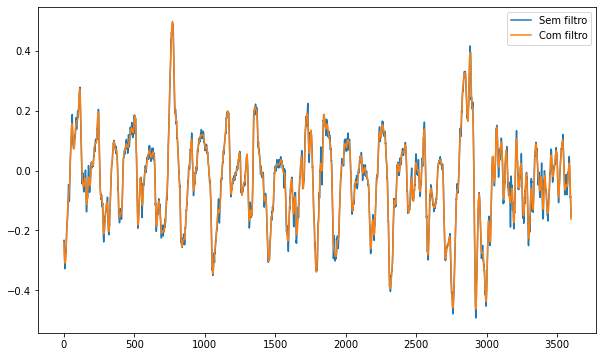

In [19]:
b, a = signal.butter(8, 0.1)
pv_filtfilt = signal.filtfilt(b, a, pv_int)

plt.figure(figsize=my_figsize)
plt.plot(pv_int.values, label='Sem filtro')
plt.plot(pv_filtfilt, label='Com filtro')
plt.legend()
plt.show()

In [20]:
fft = abs(np.fft.fft(pv_filtfilt))[: int(len(pv_int)/2)]
x = np.linspace(0, 1, len(fft))

fig = px.line(x=x, y=fft)
fig.show()